In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 5
particles = 10
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 1ms/step - loss: 2.3359 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 937us/step - loss: 2.3586 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 810us/step - loss: 2.3362 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 810us/step - loss: 2.3503 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 1ms/step - loss: 2.4043 - accuracy: 0.0880
0.08799999952316284
16/16 [==============================] - 0s 1ms/step - loss: 2.3688 - accuracy: 0.0780
0.07800000160932541
16/16 [==============================] - 0s 803us/step - loss: 2.3208 - accuracy: 0.1360
0.13600000739097595
16/16 [==============================] - 0s 873us/step - loss: 2.4364 - accuracy: 0.0980
0.09799999743700027
16/16 [==============================] - 0s 873us/step - loss: 2.3174 - accuracy: 0.1340
0.1340000033378601
16/16 [====================

bei b=6 geht was schief -> vorher steigen die Accuracies (zumindest für manche Partikel), dann wieder die 8,4 %

da wird der Loss zu groß und dadurch kommen nan

da werden die Gewichte und Bias zu groß

kleineres $h_t$ hilft (Gewichte und Bias werden langsamer groß), aber Accuracy steigt weniger (vllt auch nur langsamer)

#### Lösungsidee: 1) Batch Normalization, 2) (muss sowieso auch noch gemacht werden) Mittelwerte der Partikel

### Nach dem ersten Schleifendurchlauf erhalten wir nicht mehr die Wahrscheinlichkeiten, sondern nur noch einen 0-1-Vektor. 
Zusätzliches .fit hilft nicht. Immer neue Modelle in erster particles-Schleife helfen nicht.

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(5):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]    # loop over all batches
    for b in range(20):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        #print(y_pred_dict["model_1"])
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 95.64714765548706


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 767us/step - loss: 2.3048 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 873us/step - loss: 2.3012 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 1ms/step - loss: 2.3025 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 760us/step - loss: 2.3043 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 780us/step - loss: 2.3022 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 856us/step - loss: 2.3033 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 856us/step - loss: 2.3028 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 785us/step - loss: 11.6503 - accuracy: 0.0740
0.07400000095367432
16/16 [==============================] - 0s 934us/step - loss: 2.3025 - accuracy: 0.0900
0.09000000357627869
16/16 [===============

In [18]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1cd6e48c8>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1cd710508>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1cd6e2748>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1cd7729c8>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1cd7a2d08>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1ce7a7108>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1ce7d7588>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1ce805988>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1ce836d88>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f1ce86b248>}

In [19]:
model_dict["model_1"].get_weights()

[array([[ 0.00371145,  0.01224209, -0.00163264, ...,  0.03288485,
         -0.03678928,  0.04724072],
        [ 0.00417233,  0.01490611,  0.01116653, ...,  0.01078065,
          0.00689986, -0.00254931],
        [-0.0120053 , -0.01610985,  0.0397402 , ...,  0.01523433,
          0.02779345, -0.02441792],
        ...,
        [ 0.03191033,  0.03452877, -0.00898619, ..., -0.02234893,
          0.00171855,  0.01486274],
        [ 0.0052995 ,  0.01316929,  0.0035515 , ..., -0.02469914,
         -0.00080958,  0.01932589],
        [-0.00718671, -0.01347093,  0.00247994, ...,  0.02336107,
         -0.01707277,  0.02013581]], dtype=float32),
 array([ 0.00383978,  0.02892933,  0.05318887,  0.01339131, -0.00761958,
         0.02137559, -0.06728342,  0.0535662 ,  0.01186586,  0.04086909,
         0.00033962, -0.06091221, -0.02125639,  0.02164151,  0.00701054,
        -0.04093125, -0.04027049,  0.00202081,  0.09040969,  0.0312254 ,
         0.04645263, -0.03614808,  0.00370684, -0.03898989,  0.013

In [20]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [21]:
init_model.evaluate(X_test, y_test)[0]

16/16 [==============================] - 0s 748us/step - loss: 2.3034 - accuracy: 0.0900


2.3034160137176514

In [22]:
y_pred_dict["model_1"]

array([[0.0776336 , 0.10361802, 0.10749523, 0.12526387, 0.09696262,
        0.10078535, 0.10247809, 0.10032964, 0.0906036 , 0.09483002],
       [0.07769583, 0.10369135, 0.10746486, 0.12537552, 0.09684721,
        0.10075686, 0.10249092, 0.10036397, 0.09052171, 0.09479178],
       [0.07782789, 0.10371439, 0.1076507 , 0.1251737 , 0.09706288,
        0.1005834 , 0.10250273, 0.10012545, 0.09067244, 0.09468647],
       [0.07783775, 0.10383578, 0.10742879, 0.12497155, 0.09722235,
        0.10069821, 0.10272015, 0.10030617, 0.0904854 , 0.09449393],
       [0.07760746, 0.10371127, 0.1074079 , 0.12529765, 0.09690905,
        0.10090983, 0.10258783, 0.10044209, 0.09045605, 0.09467072],
       [0.0777184 , 0.10361749, 0.10754393, 0.12543611, 0.09688704,
        0.10077994, 0.10233442, 0.10036307, 0.09061054, 0.09470902],
       [0.07772575, 0.10351544, 0.10759069, 0.1252374 , 0.09710493,
        0.10068264, 0.10251757, 0.10040459, 0.09067196, 0.09454913],
       [0.07766607, 0.10362423, 0.1075442

In [23]:
jacobian_dict["model_1"]

array([[ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.304221 ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.303111 ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -9.512444 ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -9.4961195,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -9.441994 ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -9.814791 ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -9.300805 ,  -0.       

In [24]:
train_acc_dict

{'model_1': [0.09200000017881393,
  0.09700000286102295,
  0.08799999952316284,
  0.11100000143051147,
  0.08900000154972076,
  0.09399999678134918,
  0.09200000017881393,
  0.09399999678134918,
  0.09099999815225601,
  0.09300000220537186,
  0.0860000029206276,
  0.09399999678134918,
  0.09200000017881393,
  0.09300000220537186,
  0.09000000357627869,
  0.07699999958276749,
  0.0860000029206276,
  0.09399999678134918,
  0.09200000017881393,
  0.09399999678134918,
  0.08399999886751175,
  0.09399999678134918,
  0.09200000017881393,
  0.09399999678134918,
  0.09399999678134918,
  0.09399999678134918,
  0.0989999994635582,
  0.0989999994635582,
  0.09700000286102295,
  0.0989999994635582,
  0.09200000017881393,
  0.10000000149011612,
  0.0989999994635582,
  0.09700000286102295,
  0.09300000220537186,
  0.09300000220537186,
  0.08699999749660492,
  0.08699999749660492,
  0.08699999749660492,
  0.09300000220537186,
  0.08699999749660492,
  0.09300000220537186,
  0.09200000017881393,
  0.09

In [25]:
test_acc_dict

{'model_1': [0.09000000357627869,
  0.08799999952316284,
  0.08399999886751175,
  0.09000000357627869,
  0.09600000083446503,
  0.09000000357627869,
  0.09799999743700027,
  0.0860000029206276,
  0.09600000083446503,
  0.09000000357627869,
  0.09200000017881393,
  0.0860000029206276,
  0.09799999743700027,
  0.08799999952316284,
  0.09399999678134918,
  0.08799999952316284,
  0.09200000017881393,
  0.0860000029206276,
  0.09799999743700027,
  0.0860000029206276,
  0.09000000357627869,
  0.0860000029206276,
  0.10000000149011612,
  0.0860000029206276,
  0.0860000029206276,
  0.0860000029206276,
  0.10999999940395355,
  0.10999999940395355,
  0.08399999886751175,
  0.10999999940395355,
  0.10000000149011612,
  0.10999999940395355,
  0.08399999886751175,
  0.08399999886751175,
  0.09000000357627869,
  0.09000000357627869,
  0.07999999821186066,
  0.07999999821186066,
  0.07999999821186066,
  0.09000000357627869,
  0.07999999821186066,
  0.09000000357627869,
  0.10000000149011612,
  0.0900

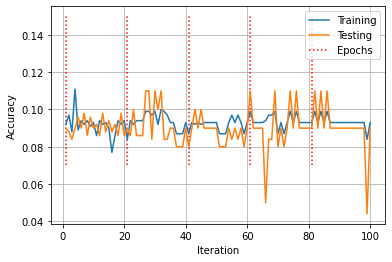

In [26]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"])